# Feature Exploration

## Importing packages and chooing work directory

In [713]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

os.chdir("C:\\Users\\maxde\\OneDrive\\Documentos\\machine_learning\\project_1") # Change this!

## Setting up

In [714]:
database = pd.read_excel("ml_project1_data.xlsx")

seed = 123

data, data_test = train_test_split(database.copy(), test_size=0.2, stratify=database["Response"], random_state=seed)

data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
180,7698,1976,PhD,Married,51650.0,0,1,2014-05-11,81,152,...,5,0,0,0,0,0,0,3,11,0
962,3547,1969,Master,Together,41021.0,1,0,2012-12-30,12,14,...,6,0,0,0,0,0,0,3,11,1
1456,4042,1971,Graduation,Divorced,43300.0,0,1,2012-10-13,87,91,...,8,0,0,0,0,0,0,3,11,1
791,10446,1957,PhD,Married,82017.0,0,0,2012-11-07,58,184,...,2,0,1,1,1,0,0,3,11,1
682,75,1982,2n Cycle,Together,41039.0,0,0,2013-07-25,32,34,...,8,0,0,0,0,0,0,3,11,0


# 1. Exploring Data
## 1.1 Missings

In [715]:
# Receives a dataframe and returns a table with missing values count, perentage and flag for higher than 3%.
def missing_rep(df):
    miss = df.isna().sum()
    miss = miss[miss>0]
    miss_p = miss/df.shape[0]
    miss_t = miss_p>0.03

    return pd.DataFrame({"Missings" : miss, "Percentage of Missings" : miss_p*100, "Higher than 3%" : miss_t})



missing_rep(data)

,Missings,Percentage of Missings,Higher than 3%
Income,20,1.116071,False


These missings will be dealt with further into our exploration.

## 1.2 Categorical Variables Analysis

#### The average response rate is almost 15%.

In [716]:
data["Response"].mean() # 15%

0.14899553571428573

#### Descriptive table of categorial features

In [717]:
# List of categorical features:
feat_c = ["Education", "Marital_Status", "Kidhome", "Teenhome", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4",
         "AcceptedCmp5", "Complain"]



# Receives dataframe, list of categorical features names(can be just 1), targer variable name,
# number of minimu observations to be taken into account and threshold of discrimination ability and
# returns a table with descriptive stats about these categorical features.
def cat_feat_describe(df, fc, target, n, thresh):

    fl = []
    
    
    
    if (type(fc)==list):
    
        for feature in fc:
            fl.append(df.groupby([feature]).agg({target : ["count", "mean"]}))    

            fm = pd.concat(fl, keys=fc)

            fm = pd.DataFrame({"Number of observations" : fm.iloc[:,0], "Discrimination ability" : fm.iloc[:,1],
                                 "More than n observations" : fm.iloc[:,0]>n,
                                 "Higher discrimination ability than the Threshold" : fm.iloc[:,1]>thresh,
                                 "Both True" : ((fm.iloc[:,0]>n) & (fm.iloc[:,1]>thresh))})
    else:
        fm = (df.groupby(fc).agg({target : ["count", "mean"]}))
        
        fm = pd.DataFrame({"Number of observations" : fm.iloc[:,0], "Discrimination ability" : fm.iloc[:,1],
                                 "More than n observations" : fm.iloc[:,0]>n,
                                 "Higher discrimination ability than the Threshold" : fm.iloc[:,1]>thresh,
                                 "Both True" : ((fm.iloc[:,0]>n) & (fm.iloc[:,1]>thresh))})
        
    return fm






feat_sum = cat_feat_describe(data, feat_c, "Response", 40, 0.15)
feat_sum

Number of observations  Discrimination ability  \
Education      2n Cycle                       167                0.077844   
               Basic                           41                0.024390   
               Graduation                     905                0.133702   
               Master                         292                0.154110   
               PhD                            387                0.224806   
Marital_Status Absurd                           2                0.500000   
               Alone                            3                0.333333   
               Divorced                       179                0.201117   
               Married                        684                0.118421   
               Single                         386                0.207254   
               Together                       472                0.105932   
               Widow                           64                0.265625   
               YOLO                             2                0.500000   
Kidhome        0                             1035                0.170048   
               1                              718                0.123955   
               2                               39                0.051282   
Teenhome       0                              937                0.203842   
               1                              812                0.088670   
               2                               43                0.093023   
AcceptedCmp1   0                             1673                0.120741   
               1                              119                0.546218   
AcceptedCmp2   0                             1769                0.142453   
               1                               23                0.652174   
AcceptedCmp3   0                             1661                0.124022   
               1                              131                0.465649   
AcceptedCmp4   0                             1652                0.130145   
               1                              140                0.371429   
AcceptedCmp5   0                             1656                0.114130   
               1                              136                0.573529   
Complain       0                             1773                0.149464   
               1                               19                0.105263   

                           More than n observations  \
Education      2n Cycle                        True   
               Basic                           True   
               Graduation                      True   
               Master                          True   
               PhD                             True   
Marital_Status Absurd                         False   
               Alone                          False   
               Divorced                        True   
               Married                         True   
               Single                          True   
               Together                        True   
               Widow                           True   
               YOLO                           False   
Kidhome        0                               True   
               1                               True   
               2                              False   
Teenhome       0                               True   
               1                               True   
               2                               True   
AcceptedCmp1   0                               True   
               1                               True   
AcceptedCmp2   0                               True   
               1                              False   
AcceptedCmp3   0                               True   
               1                               True   
AcceptedCmp4   0                               True   
               1                               True   
AcceptedCmp5   0      

#### These states of these classes show both decent number of observations and a discrimination ability higher than 15%.

In [718]:
feat_sum[feat_sum["Both True"]]

Number of observations  Discrimination ability  \
Education      Master                       292                0.154110   
               PhD                          387                0.224806   
Marital_Status Divorced                     179                0.201117   
               Single                       386                0.207254   
               Widow                         64                0.265625   
Kidhome        0                           1035                0.170048   
Teenhome       0                            937                0.203842   
AcceptedCmp1   1                            119                0.546218   
AcceptedCmp3   1                            131                0.465649   
AcceptedCmp4   1                            140                0.371429   
AcceptedCmp5   1                            136                0.573529   

                         More than n observations  \
Education      Master                        True   
               PhD                           True   
Marital_Status Divorced                      True   
               Single                        True   
               Widow                         True   
Kidhome        0                             True   
Teenhome       0                             True   
AcceptedCmp1   1                             True   
AcceptedCmp3   1                             True   
AcceptedCmp4   1                             True   
AcceptedCmp5   1                             True   

                         Higher discrimination ability than the Threshold  \
Education      Master                                                True   
               PhD                                                   True   
Marital_Status Divorced                                              True   
               Single                                                True   
               Widow                                                 True   
Kidhome        0                                                     True   
Teenhome       0                                                     True   
AcceptedCmp1   1                                                     True   
AcceptedCmp3   1                                                     True   
AcceptedCmp4   1                                                     True   
AcceptedCmp5   1                                                     True   

                         Both True  
Education      Master         True  
               PhD            True  
Marital_Status Divorced       True  
               Single         True  
               Widow          True  
Kidhome        0              True  
Teenhome       0              True  
AcceptedCmp1   1              True  
AcceptedCmp3   1              True  
AcceptedCmp4   1              True  
AcceptedCmp5   1              True

#### States of classes with few observations

We can observe that there are three status of the categorial variable Marital_Status that hold few observations while not fitting into the common marital status we know. We should remove these observations.

In [719]:
feat_sum[-feat_sum["More than n observations"]]

Number of observations  Discrimination ability  \
Marital_Status Absurd                       2                0.500000   
               Alone                        3                0.333333   
               YOLO                         2                0.500000   
Kidhome        2                           39                0.051282   
AcceptedCmp2   1                           23                0.652174   
Complain       1                           19                0.105263   

                       More than n observations  \
Marital_Status Absurd                     False   
               Alone                      False   
               YOLO                       False   
Kidhome        2                          False   
AcceptedCmp2   1                          False   
Complain       1                          False   

                       Higher discrimination ability than the Threshold  \
Marital_Status Absurd                                              True   
               Alone                                               True   
               YOLO                                                True   
Kidhome        2                                                  False   
AcceptedCmp2   1                                                   True   
Complain       1                                                  False   

                       Both True  
Marital_Status Absurd      False  
               Alone       False  
               YOLO        False  
Kidhome        2           False  
AcceptedCmp2   1           False  
Complain       1           False

#### Removing Uncommon Categories in Marital_Status

In [720]:
data_ = data[data["Marital_Status"] != "Alone"]
data_ = data_[data_["Marital_Status"] != "Absurd"]
data_ = data_[data_["Marital_Status"] != "YOLO"]

In [721]:
data_.groupby("Marital_Status").count().index

Index(['Divorced', 'Married', 'Single', 'Together', 'Widow'], dtype='object', name='Marital_Status')

#### Visualization of Discrimination Ability of Categorical Features

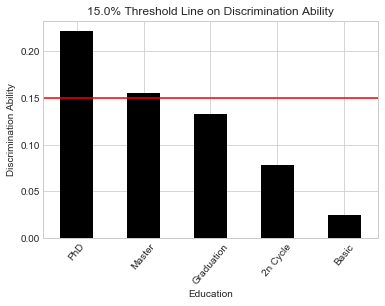

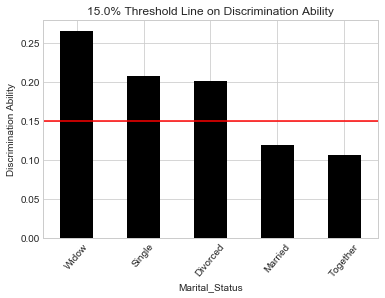

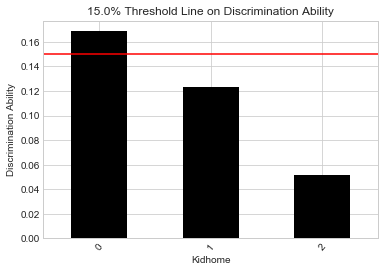

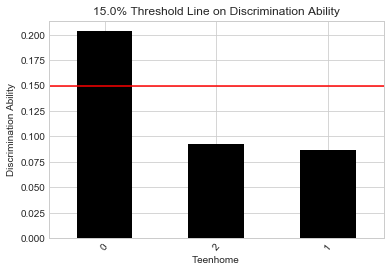

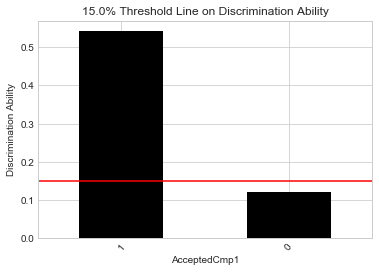

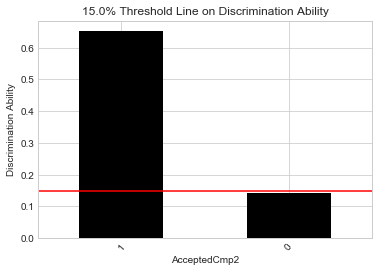

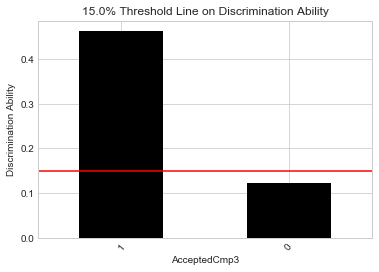

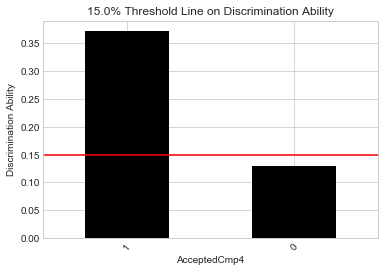

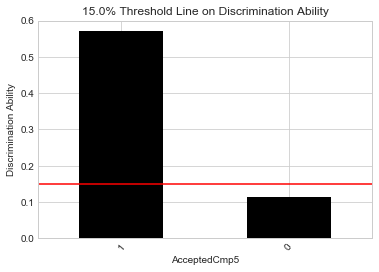

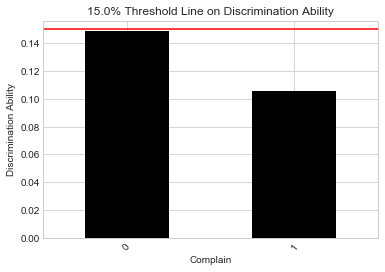

In [722]:
# Takes a dataframe, list of categorical features names (can be 1), the target variable name
# and the trheshold of discrimination ability and outputs all plots.
def cat_feat_plot(df, fc, target, thresh):

    sns.set_style("whitegrid")

    if (type(fc)==str):
        plot_df = cat_feat_describe(df, fc, target, 50, thresh).iloc[:,1]

        plot_df = plot_df.sort_values(ascending=False)

        ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
        ax.set_ylabel("Discrimination Ability", size = 10)
        ax.axhline(y=thresh, color="red")
        ax.set_xticklabels(plot_df.index, rotation=50, size=10)


        plt.show()
        
        
        
    else:
        for feat in fc:
            plot_df = cat_feat_describe(df, feat, target, 50, thresh).iloc[:,1]

            plot_df = plot_df.sort_values(ascending=False)

            
            
            ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
            ax.set_ylabel("Discrimination Ability", size = 10)
            ax.axhline(y=thresh, color="red")
            ax.set_xticklabels(plot_df.index, rotation=50, size=10)


            plt.show()
        
        
        
        
        
    
cat_feat_plot(data_, feat_c, "Response", 0.15)

## 1.3 Numerical Variables Analysis

#### Dt_Customer into days since registration

In [723]:
# Gets a series of dates and its format as parameters and returns a series of days since that date until today.
def days_since(dates_series, date_format):

    n = len(dates_series)
    
    result = [0] * n

    for i in range(n):
        result[i] = (datetime.today()-datetime.strptime(dates_series[i], date_format)).days
    
    return result



data_["Days_Customer"] = days_since(list(data_.Dt_Customer), "%Y-%m-%d")

data_["Days_Customer"].head()

180     1783
962     2280
1456    2358
791     2333
682     2073
Name: Days_Customer, dtype: int64

In [724]:
feat_n = list(data_.columns)

feat_n = list(filter(lambda x: x not in feat_c, feat_n))

feat_n.remove("ID") # Removing ID.
feat_n.remove("Dt_Customer") # Removing Dt_Customer, as we now have the Days_Customer covering that information.
# List of Numerical Variables

data_[feat_n].describe() # Describing only Numerical Variables

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Days_Customer
count,1785.000000,1765.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000,1785.0,1785.0,1785.000000,1785.000000
mean,1968.780952,52566.935977,49.386555,305.642577,26.340616,170.972549,37.792157,28.018487,44.183193,2.319888,4.073389,2.690196,5.810084,5.287955,3.0,11.0,0.147899,2084.298599
std,11.822334,26378.919801,29.010757,341.007849,39.612649,231.885730,54.604242,42.613028,52.365743,1.961848,2.787442,2.985360,3.269013,2.456801,0.0,0.0,0.355099,202.775495
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,1734.000000
25%,1959.000000,34916.000000,25.000000,23.000000,1.000000,15.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0,0.000000,1907.000000
50%,1970.000000,51766.000000,50.000000,173.000000,8.000000,69.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0,0.000000,2085.000000
75%,1977.000000,69084.000000,75.000000,508.000000,33.000000,241.000000,50.000000,35.000000,57.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0,0.000000,2257.000000
max,1996.000000,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0,1.000000,2433.000000


#### Variables with zero variance (constants)

In [725]:
std = data_[feat_n].describe().iloc[2,:]
std[std<0.05]

Z_CostContact    0.0
Z_Revenue        0.0
Name: std, dtype: float64

#### Removing constant variables

In [726]:
const = [std[std<0.05].index[0], std[std<0.05].index[1]]

data_.drop(labels=const, axis=1, inplace=True) # Now data_ does not contain zero variance variables.


feat_n = list(filter(lambda x: x not in const, feat_n)) # Removing the names of the no varaiance variables
                                                        # from the list of numerical features.

#### Correlation Matrix between numerical variables

We employ the correlation matrix here in order to find variables that show high correlation between them so we could eliminate one or join them.

As we can see, though, the highest correlation found is between Income and Number of Monthly Web Visits, which is not high enough to present a collinearity problem (-0.55).

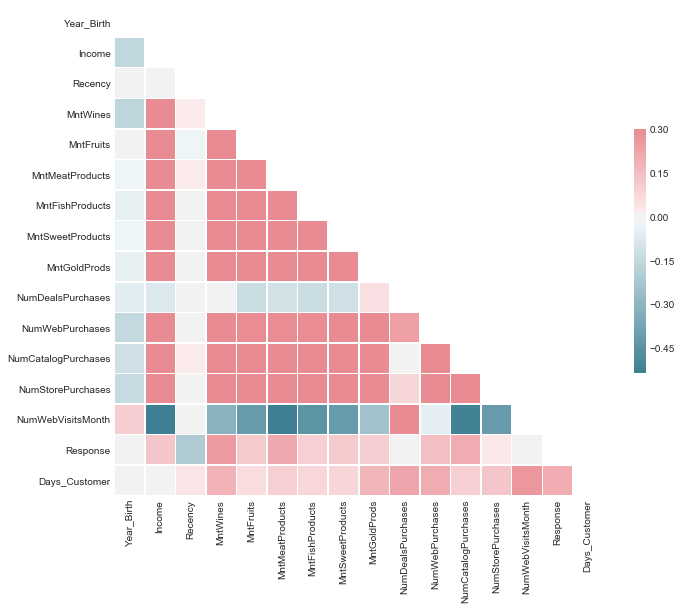

In [727]:
# Takes a dataframe and returns the correlation matrix while plotting the correlation matrix plot using hues of blue and red.
def corr_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()
    return corr

corr = corr_matrix(data_[feat_n])

In [728]:
print("Correlation between Income and Number of Monthly Web Visits:", format(corr.loc["Income", "NumWebVisitsMonth"], ".2f"))

Correlation between Income and Number of Monthly Web Visits: -0.54


#### Visualization of Numerical Variables

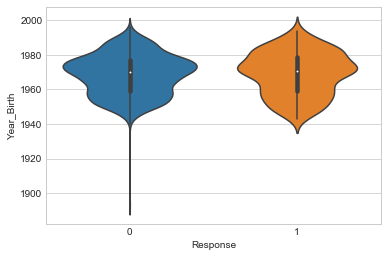

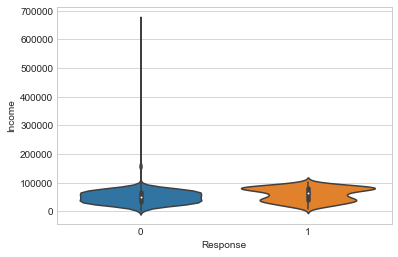

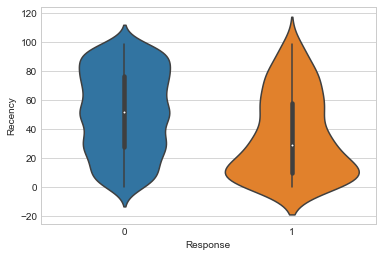

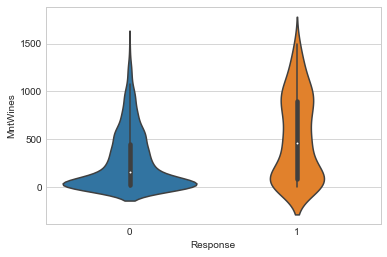

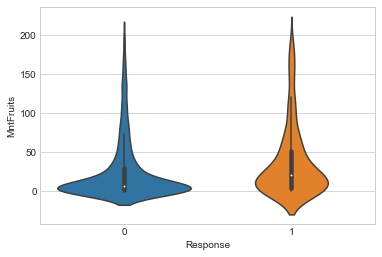

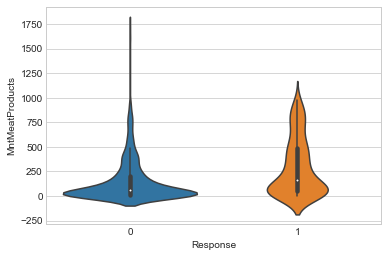

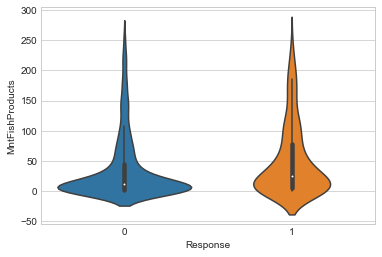

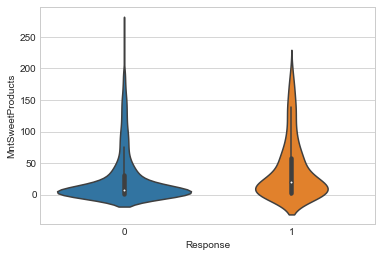

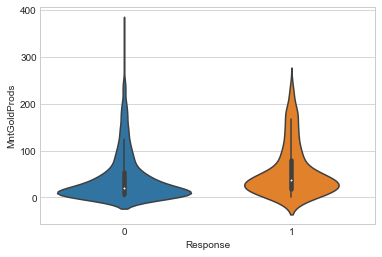

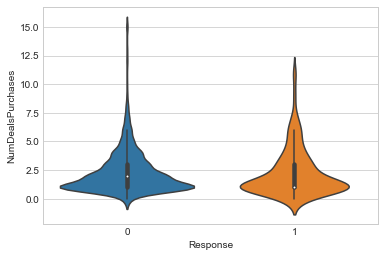

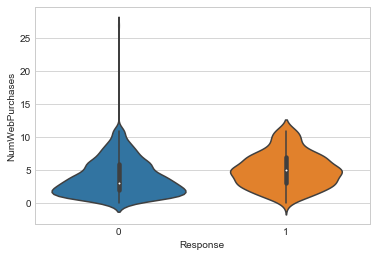

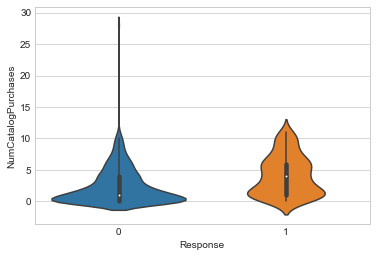

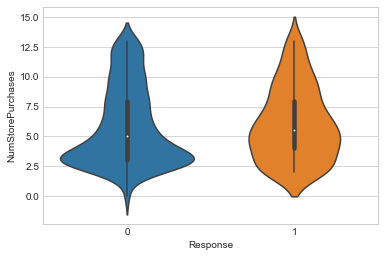

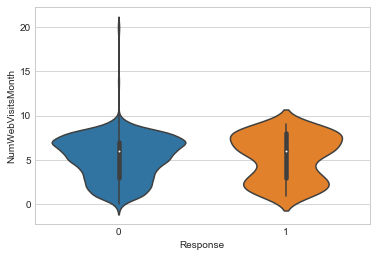

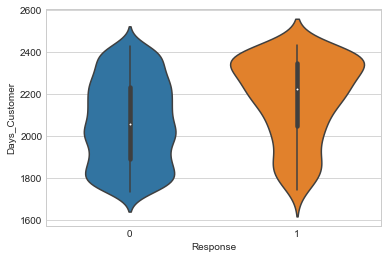

In [730]:
# Can give from 1 to all of numeric features a feat_n.
# Can give a categorical feature to be used (optional).
def num_feat_plot(df, feat_nlist, target, feat_clist = None):
    
    if(target in feat_nlist):
        feat_nl = feat_nlist.copy()
        feat_nl.remove(target)
    
    if (feat_clist==None):
        
        if (type(feat_nl)==str):
            
            sns.violinplot(data = df, y = feat_nl, x = target)
            plt.show()
            
            
        else:
            for feat in feat_nl:
                sns.violinplot(data = df, y = feat, x = target)
                plt.show()
        
    else:
        if (type(feat_nl)==str):
            
            sns.violinplot(data = data_, y = feat_nl, x = feat_clist, hue = target)
            plt.show()
            
            
        else:
            for feat in feat_nl:
                sns.violinplot(data = data_, y = feat, x = feat_clist, hue = target)
                plt.show()
                
    return

num_feat_plot(data_, feat_n, "Response")

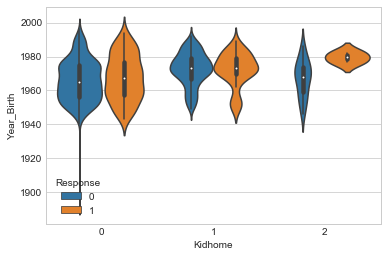

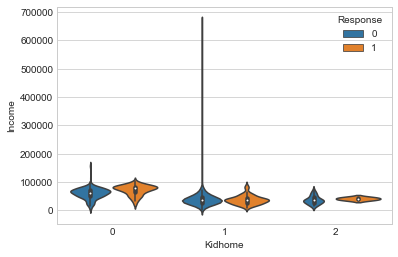

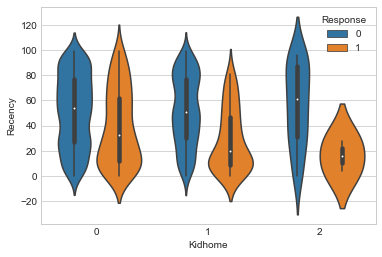

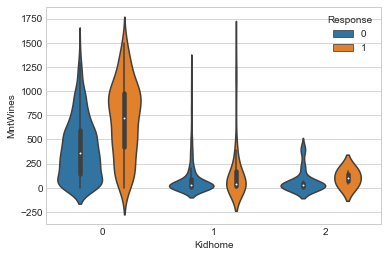

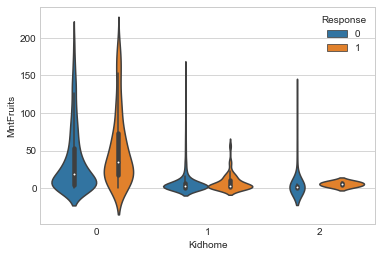

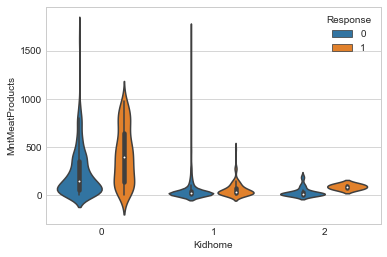

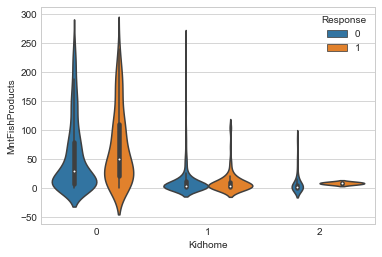

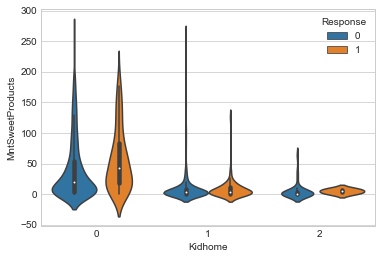

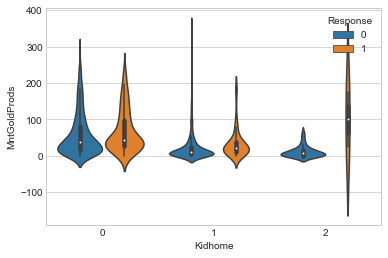

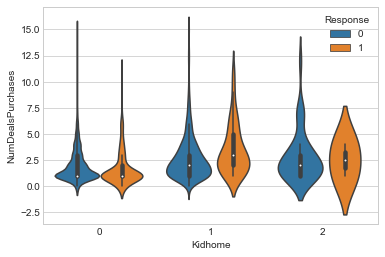

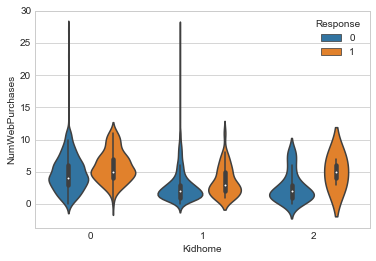

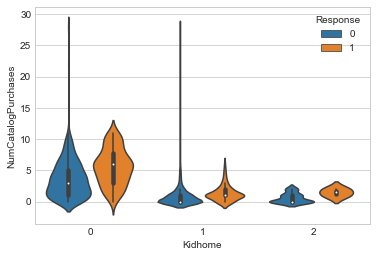

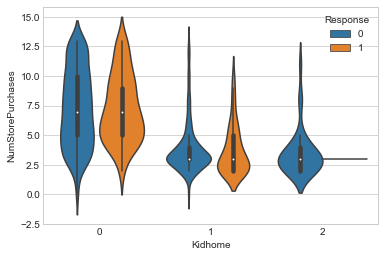

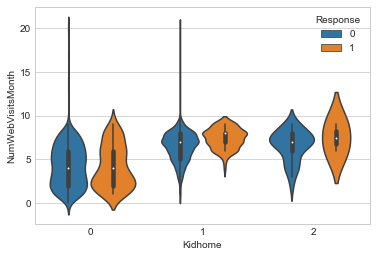

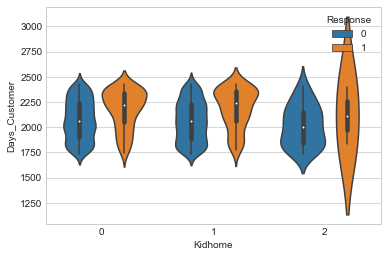

In [731]:
num_feat_plot(data_, feat_n, "Response", "Kidhome")